<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Data pre-processing</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Clean text

In [1]:
import _mypath
import os
import pandas as pd
import re
import spacy 
import csv
from tqdm import tqdm

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1

In [2]:
DATA_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/processed"
OUT_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/labeled"

# Data loading

In [3]:
infile = os.path.join(DATA_FOLDER, "cleaned_merged_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")
print("data shape:", df.shape, end="\n\n")

df.head()

data shape: (105568, 8)



,Commentaire,star,date,client,reponse,source,company,langage
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr


# Data prep

## Cleaning (digits, max length 20, stops words, punctuations, lower case...)

In [4]:
def cleanReview(text):
    pattern_email = re.compile(r"[a-zA-Z0-9.-]+@[a-zA-Z.]+")
    pattern_url1 = re.compile(r"https?://[a-zA-Z0-9./]+")
    pattern_url2 = re.compile(r"www\.[a-zA-Z0-9.-:/]+")

    text = pattern_email.sub(" ", text)
    text = pattern_url1.sub(" ", text)
    text = pattern_url2.sub(" ", text)
    text = re.sub(r' {2,}', " ", text)
    return text

def preprocess_word(token):
    if token.text.isnumeric(): return ""
    if len(token.text)<2 or len(token.text)>20: return ""
    if token.is_stop: return ""
    if token.ent_type_ == "PUNCT": return ""
    word = re.sub(r'[\@\#\$\*\-\=\+\~\|\°]', " ", token.text)
    word = re.sub(r' {2,}', " ", word)
    return word.strip()

def preprocess_lemma(token):
    if token.text.isnumeric(): return ""
    if len(token.text)<2 or len(token.text)>20: return ""
    if token.is_stop: return ""
    if token.ent_type_ == "PUNCT": return ""
    return token.lemma_

In [5]:
nlp = spacy.load("fr_core_news_lg")

In [6]:
gen = nlp.pipe(df.Commentaire.str.lower().map(cleanReview), disable=["tagger", "parser", "attribute_ruler", "textcat"], n_process=5, batch_size=100)

liste_lemma, list_words = [], []
for doc in tqdm(gen) : 
    text_preprocess = " ".join(preprocess_word(token) for token in doc)
    list_words.append(text_preprocess)

    text_preprocess = " ".join(preprocess_lemma(token) for token in doc)
    liste_lemma.append(text_preprocess)

df['cleaned_words'] = list_words
df['cleaned_lemma'] = liste_lemma
df.head(5)

105568it [01:31, 1153.74it/s]


,Commentaire,star,date,client,reponse,source,company,langage,cleaned_words,cleaned_lemma
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,amazon politique pire contrairement ...
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service ...,prelev commande jamais recevoir servi...
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...


In [7]:
df.isna().sum()

Commentaire          0
star                 0
date                 0
client               0
reponse          80905
source               0
company              0
langage              0
cleaned_words        0
cleaned_lemma        0
dtype: int64

In [57]:
df["cleaned_lemma"] = df["cleaned_lemma"].str.strip()
df["cleaned_words"] = df["cleaned_words"].str.strip()

In [58]:
mask = (df["cleaned_words"].str.strip().str.len()==0) | (df["cleaned_lemma"].str.strip().str.len()==0)
print("empty processed texts:", mask.sum())

empty processed texts: 57


In [59]:
df = pd.DataFrame(df[~mask])

mask = (df["cleaned_words"].str.strip().str.len()==0) | (df["cleaned_lemma"].str.strip().str.len()==0)
print("empty processed texts:", mask.sum())

empty processed texts: 0


In [60]:
df.head(5)

,Commentaire,star,date,client,reponse,source,company,langage,cleaned_words,cleaned_lemma,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...,__label__NEGATIVE
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,amazon politique pire contrairement ...,__label__NEGATIVE
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...,__label__POSITIVE
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service cl...,prelev commande jamais recevoir service...,__label__NEGATIVE
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...,__label__NEGATIVE


In [61]:
outfile = os.path.join(DATA_FOLDER, "processed_dataset.csv")
df.to_csv(outfile, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

# DATASET SPLIT
## Binary classes

In [62]:
RATIO_DSPLIT = 0.8

In [63]:
df_train = pd.DataFrame()
df_val= pd.DataFrame()
df_test = pd.DataFrame()

for sentiment in ["__label__NEGATIVE", "__label__POSITIVE"]:
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)

    split_val_index = int(tmp.shape[0] * RATIO_DSPLIT*RATIO_DSPLIT)
    split_test_index = int(tmp.shape[0] * RATIO_DSPLIT)

    df_train = pd.concat((df_train, tmp.iloc[:split_val_index]))
    df_val = pd.concat((df_val, tmp.iloc[split_val_index:split_test_index]))
    df_test = pd.concat((df_test, tmp.iloc[split_test_index:]))

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (63459, 11)
val set: (15865, 11)
test set: (19832, 11)


In [65]:
outfile_2cls_train = os.path.join(OUT_FOLDER, "train_2classes.csv")
df_train.to_csv(outfile_2cls_train, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_2cls_val = os.path.join(OUT_FOLDER, "val_2classes.csv")
df_val.to_csv(outfile_2cls_val, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_2cls_test = os.path.join(OUT_FOLDER, "test_2classes.csv")
df_test.to_csv(outfile_2cls_test, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

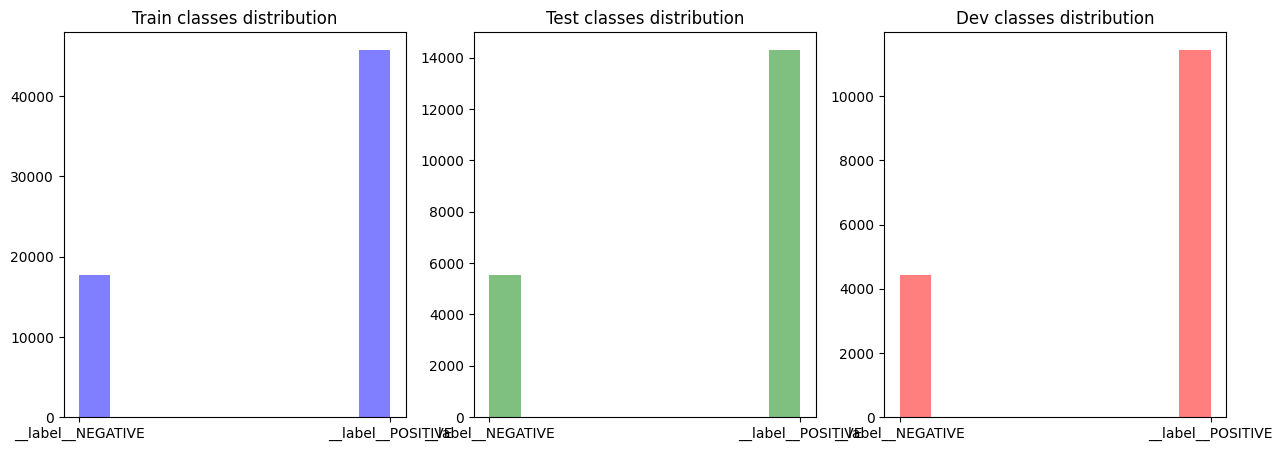

In [66]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de dev
axs[2].hist(df_val["Sentiment"], color='red', alpha=0.5)
axs[2].set_title('Dev classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

## 3 Classes

In [67]:
df_train = pd.DataFrame()
df_val= pd.DataFrame()
df_test = pd.DataFrame()

for sentiment in df["Sentiment"].unique():
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)

    split_val_index = int(tmp.shape[0] * RATIO_DSPLIT*RATIO_DSPLIT)
    split_test_index = int(tmp.shape[0] * RATIO_DSPLIT)

    df_train = pd.concat((df_train, tmp.iloc[:split_val_index]))
    df_val = pd.concat((df_val, tmp.iloc[split_val_index:split_test_index]))
    df_test = pd.concat((df_test, tmp.iloc[split_test_index:]))

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (67526, 11)
val set: (16882, 11)
test set: (21103, 11)


In [68]:
outfile_3cls_train = os.path.join(OUT_FOLDER, "train_3classes.csv")
df_train.to_csv(outfile_3cls_train, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_3cls_val = os.path.join(OUT_FOLDER, "val_3classes.csv")
df_val.to_csv(outfile_3cls_val, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_3cls_test = os.path.join(OUT_FOLDER, "test_3classes.csv")
df_test.to_csv(outfile_3cls_test, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

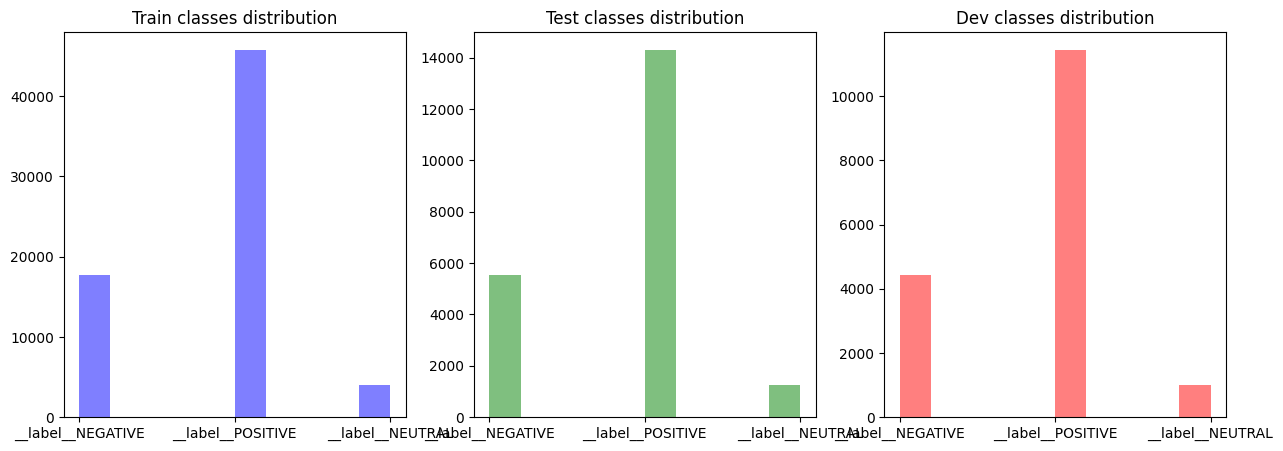

In [69]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de dev
axs[2].hist(df_val["Sentiment"], color='red', alpha=0.5)
axs[2].set_title('Dev classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

## 5 classes

In [70]:
df_train = pd.DataFrame()
df_val= pd.DataFrame()
df_test = pd.DataFrame()

for star in df["star"].unique():
    mask = (df["star"]==star)
    tmp = df.loc[mask].sample(frac=1)

    split_val_index = int(tmp.shape[0] * RATIO_DSPLIT*RATIO_DSPLIT)
    split_test_index = int(tmp.shape[0] * RATIO_DSPLIT)

    df_train = pd.concat((df_train, tmp.iloc[:split_val_index]))
    df_val = pd.concat((df_val, tmp.iloc[split_val_index:split_test_index]))
    df_test = pd.concat((df_test, tmp.iloc[split_test_index:]))

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (67525, 11)
val set: (16882, 11)
test set: (21104, 11)


In [71]:
outfile_5cls_train = os.path.join(OUT_FOLDER, "train_5classes.csv")
df_train.to_csv(outfile_5cls_train, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_5cls_val = os.path.join(OUT_FOLDER, "val_5classes.csv")
df_val.to_csv(outfile_5cls_val, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

outfile_5cls_test = os.path.join(OUT_FOLDER, "test_5classes.csv")
df_test.to_csv(outfile_5cls_test, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

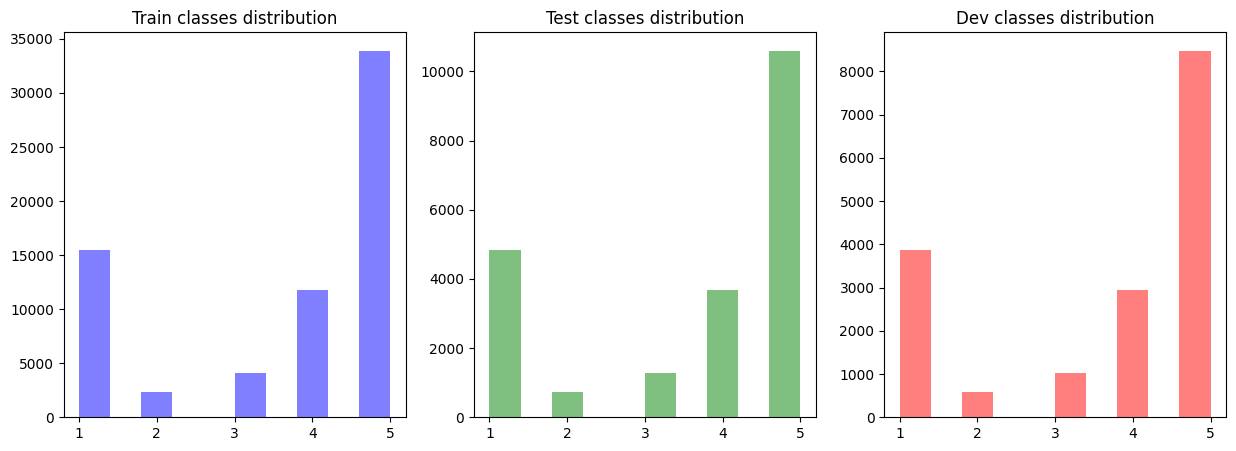

In [72]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train["star"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de dev
axs[2].hist(df_val["star"], color='red', alpha=0.5)
axs[2].set_title('Dev classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test["star"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()